In [95]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch
import random

In [43]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [88]:
class Value:
    def __init__(self, data, _children=(), _op ='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def _build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    _build_topo(child)
                topo.append(v)
        _build_topo(self)
        self.grad = 1.0;
        for node in reversed(topo):
            node._backward()

In [44]:
x1 = Value(2.0); x1.label='x1'
x2 = Value(0.0); x2.label='x2'
w1 = Value(-3.0); w1.label='w1'
w2 = Value(1.0); w2.label='w2'
b = Value(6.8813735870195432); b.label='b'
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2+b; n.label='x1*w1+x2*w2+b'
o = n.tanh(); o.label='o'

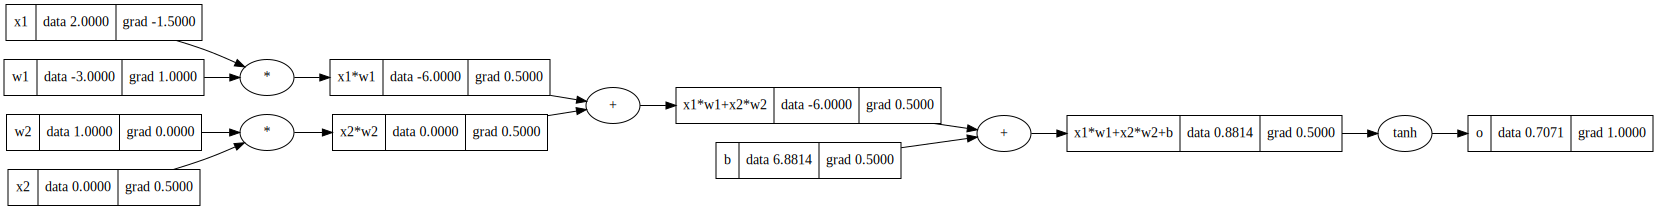

In [47]:
draw_dot(o)

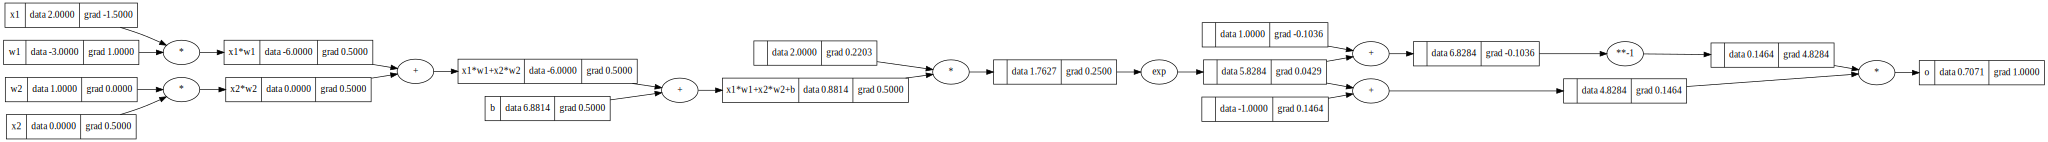

In [91]:
x1 = Value(2.0); x1.label='x1'
x2 = Value(0.0); x2.label='x2'
w1 = Value(-3.0); w1.label='w1'
w2 = Value(1.0); w2.label='w2'
b = Value(6.8813735870195432); b.label='b'
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2+b; n.label='x1*w1+x2*w2+b'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label='o'
o.backward()
draw_dot(o)

In [128]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)),  self.b)
        out = act.tanh()
        return out
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Value(data=-0.5880957439117029)